# Latent Semantic Analysis

Latent Semantic Analysis is a natural language processing method that analyzes relationships between a set of documents and the terms contained within. It uses singular value decomposition, a mathematical technique, to scan unstructured data to find hidden relationships between terms and concepts.

In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegressionCV
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier


### Load in the Labelled Dataset

In [2]:
dfR = pd.read_csv(r'dfRLabelled.csv')
dfR.head(3)

,Unnamed: 0.1,Unnamed: 0,Product,Reviewer Name,Rating,Text,Date,Country,ASIN,Language,Rules,Label
0,0,0,"Wireless Earbuds, yobola Bluetoth Earbuds, IPX...",Will of Burr,1.0 out of 5 stars,"I am a real fan of headphones, probably becaus...",11/17/2022,United States 🇺🇸,B09LCVHCVX,en,"3, 4, 5, 7 :",Suspicious
1,1,1,"Wireless Earbuds, yobola Bluetoth Earbuds, IPX...",Allen Pak,5.0 out of 5 stars,To be honest. I wasn't expecting much when I ...,10/25/2022,United States 🇺🇸,B09LCVHCVX,en,NaN,Not Suspicious
2,2,2,"Wireless Earbuds, yobola Bluetoth Earbuds, IPX...",brenda,5.0 out of 5 stars,1st off they connected very easily which is al...,11/29/2022,United States 🇺🇸,B09LCVHCVX,en,"3, 4, 6 :",Suspicious


In [3]:
dfR.shape

(2055, 12)

### Remove Reviews with No Text

In [4]:
dfR = dfR[dfR['Text'].notna()]
dfR.shape

(2011, 12)

### Vectorize Reviews

In [5]:
Vectorizer = TfidfVectorizer(analyzer='word',stop_words='english', ngram_range=(1,1))
X          = Vectorizer.fit_transform(dfR.Text)
print(X.shape)
# No target y as latent semantic analysis is unsupervised.
vocabulary = pd.Series(Vectorizer.get_feature_names_out())

(2011, 3192)


### Compress Features

In [6]:
num_components_list = list(range(1,30))
str_num_components_list = [str(i) for i in num_components_list]
component_variances = []
for component in num_components_list:
  svd = TruncatedSVD(n_components = component)
  Xc = svd.fit_transform(X)
  component_variances.append(svd.explained_variance_ratio_.sum().round(3))
print(component_variances)

[0.014, 0.033, 0.046, 0.057, 0.068, 0.078, 0.088, 0.098, 0.107, 0.115, 0.123, 0.131, 0.138, 0.145, 0.152, 0.158, 0.165, 0.171, 0.177, 0.183, 0.189, 0.194, 0.2, 0.205, 0.21, 0.215, 0.22, 0.225, 0.23]


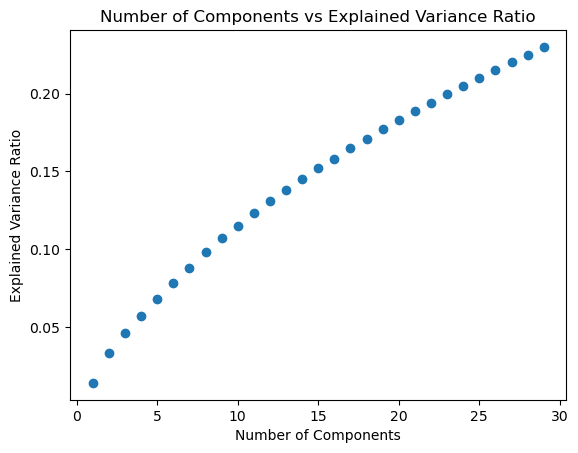

In [7]:
import matplotlib.pyplot as plt
plt.scatter(num_components_list, component_variances)
plt.title('Number of Components vs Explained Variance Ratio')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.show()

23.5% of the variance in reviews is explained by the top 30 principle components.

In [8]:
Xc = pd.DataFrame(Xc)
# Allows for concatenating successfully
dfR = dfR.reset_index()
dfR_reduced = pd.concat([dfR.Text, dfR.Label,Xc],axis=1)
dfR_reduced.head(3)

,Text,Label,0,1,2,3,4,5,6,7,...,19,20,21,22,23,24,25,26,27,28
0,"I am a real fan of headphones, probably becaus...",Suspicious,0.238804,-0.055256,-0.195495,-0.124769,-0.065552,-0.066278,-0.004066,0.003892,...,0.004540,0.054032,0.059995,-0.055395,-0.091104,0.078151,-0.061675,0.071337,-0.013967,0.052318
1,To be honest. I wasn't expecting much when I ...,Not Suspicious,0.334092,-0.095783,-0.149166,-0.006435,-0.077695,-0.151898,-0.022999,-0.024312,...,-0.150447,0.071133,0.000153,0.019140,-0.046512,0.091784,0.025456,-0.045702,0.061490,-0.094939
2,1st off they connected very easily which is al...,Suspicious,0.190134,-0.071170,-0.158540,-0.095621,-0.062029,-0.036417,0.009788,0.003825,...,-0.119402,0.025543,-0.021446,0.028658,0.059156,0.024968,-0.026216,-0.100372,-0.031428,-0.071464


In [9]:
k = 28
ix = [0,1,2,3,4,5,-5,-4,-3,-2,-1]
dfR_reduced[dfR_reduced.Label == 'Not Suspicious'].sort_values(k,ascending=False).iloc[ix,:][['Text','Label',k]].round(2)

,Text,Label,28
488,Good headphones,Not Suspicious,0.30
148,Price is amazing and the sound is amazing,Not Suspicious,0.26
1228,Good quality headphones,Not Suspicious,0.24
1783,"Amazing set of headphones, work really well an...",Not Suspicious,0.23
1188,Amazing sound quality,Not Suspicious,0.22
515,"Sound great, amazing price and arrived same da...",Not Suspicious,0.22
237,Fit well and music sounds great!,Not Suspicious,-0.21
1486,"Easy to connect to Bluetooth, comfortable - mu...",Not Suspicious,-0.22
1505,Look just like Airpods,Not Suspicious,-0.22
323,Just as comfortable as Apple AirPods and easy ...,Not Suspicious,-0.23


In [10]:
# view components in terms of vocabulary
components = svd.components_

k = 28
component = pd.Series(components[k,:],index=vocabulary)
component.sort_values(ascending=False)[ix].round(2)

headphones    0.35
brilliant     0.22
amazing       0.21
sound         0.19
fall          0.15
pair          0.11
apple        -0.19
long         -0.21
fit          -0.21
better       -0.26
airpods      -0.30
dtype: float64

In [11]:
components[1,:]

array([ 0.00014544, -0.01795769, -0.00435662, ..., -0.00060178,
       -0.00070839, -0.00158877])

In latent semantic analysis, documents are compared by cosine similarity between any two columns. Values close to 1 represent very similar documents while values close to 0 represent very dissimilar documents. As 'good' has a 0.77 component value, there is a strong association within that component.

# Logistic Regression

### Train-Test Split

In [12]:
X = dfR_reduced.drop(['Text', 'Label'], axis=1)
y = dfR.Label
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7, stratify = y, random_state=0)

In [13]:
X_test.shape

(604, 29)

### Fit Model

In [14]:
# Look at regularization values
logisticRegr = LogisticRegressionCV(penalty='l1', solver='liblinear')
lrModel = logisticRegr.fit(X_train, y_train)

### Examine Coefficients

In [15]:
# Look at words associated with top components 
model_coefs = pd.Series(lrModel.coef_.ravel(), index=X_train.columns.tolist())
model_coefsDF = pd.DataFrame(model_coefs, columns = ['Coefficients'])
#model_coefsDF.sort_values(by='Coefficients', ascending=False).head(5)
model_coefsDF.sort_values(by='Coefficients', ascending=False).tail(5)

,Coefficients
23,-2.324532
3,-2.498928
14,-2.650724
28,-3.758973
0,-4.003701


### Examine Test Accuracy

In [16]:
predictions = logisticRegr.predict(X_test)

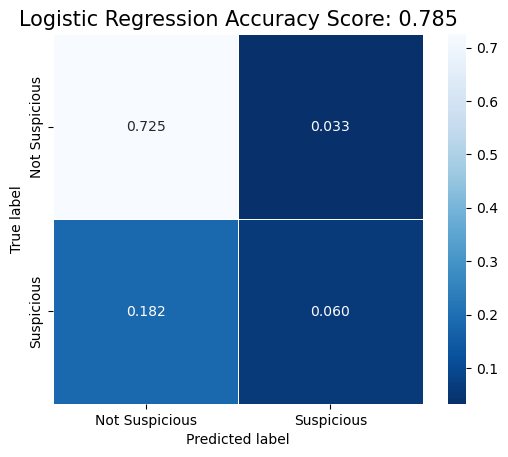

In [17]:
score = logisticRegr.score(X_test, y_test)
cm = metrics.confusion_matrix(y_test, predictions, normalize='all')
#plt.figure(figsize=(9,9))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r', ax=ax);
plt.ylabel('True label');
plt.xlabel('Predicted label');
all_sample_title = 'Logistic Regression Accuracy Score: {0}'.format(score.round(3))
plt.title(all_sample_title, size = 15);
ax.xaxis.set_ticklabels(['Not Suspicious', 'Suspicious']); ax.yaxis.set_ticklabels(['Not Suspicious', 'Suspicious']);

We will let the null hypothesis, $H_0$, be that the review is not suspicious. Thus, the alternative hypothesis, $H_a$, is that the review is suspicious. Predicting a suspicious review to be not suspicious is a more serious error in this case given that the end goal is to identify suspicious reviews for both the consumer and distributor. Incorrectly labelling not suspicious reviews as suspicious would be the more preferable error as this aligns with the principle of erring on the side of caution. In terms of statistical hypothesis testing, this translates to committing a type II error being of more importance than committing a type I error. Within the testing set, the probability of committing a type II error is 0.195.

# Random Forests

### Fit the Model

In [18]:
rf_params = {"n_estimators" :[100,200,500,1000],  
             "max_depth": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}

rf_model = RandomForestClassifier(random_state = 0)

rf_cv_model = GridSearchCV(rf_model, rf_params, cv = 10, n_jobs = -1,verbose = 1).fit(X_train, y_train)

rf_tuned = RandomForestClassifier(**rf_cv_model.best_params_).fit(X_train, y_train)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


### Examine Training Accuracy

In [ ]:
tuned = [rf_tuned]
print("Best Model Parameters and Scores:")
for i in tuned:
    score = cross_val_score(i, X_train, y_train, cv = 10).mean()
    testScore = cross_val_score(i, X_test, y_test, cv=10).mean()
    print(i,"Train Score:",score)
    print(i, "Test Score", testScore)

Best Model Parameters and Scores:


### Predict Labels

In [ ]:
predictions = rf_tuned.predict(X_test)

In [ ]:
score = rf_tuned.score(X_test, y_test)
cm = metrics.confusion_matrix(y_test, predictions, normalize='all')
#plt.figure(figsize=(9,9))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r', ax=ax);
plt.ylabel('True label');
plt.xlabel('Predicted label');
all_sample_title = 'Random Forests Accuracy Score: {0}'.format(score.round(3))
plt.title(all_sample_title, size = 15);
ax.xaxis.set_ticklabels(['Not Suspicious', 'Suspicious']); ax.yaxis.set_ticklabels(['Not Suspicious', 'Suspicious']);

# Support Vector Machines

### Fit the Model

In [ ]:
svm_params = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]

In [ ]:
svm_model = svm.SVC(random_state = 0)
svm_cv_model = GridSearchCV(svm_model, svm_params, cv = 10, n_jobs = -1,verbose = 1).fit(X_train, y_train)
svm_tuned = svm.SVC(**svm_cv_model.best_params_).fit(X_train, y_train)

In [ ]:
tuned = [svm_tuned]
print("Best Model Parameters and Scores:")
for i in tuned:
    score = cross_val_score(i, X_train, y_train, cv = 10).mean()
    testScore = cross_val_score(i, X_test, y_test, cv=10).mean()
    print(i,"Train Score:",score)
    print(i, "Test Score", testScore)

### Predict Labels

In [ ]:
predictions = svm_tuned.predict(X_test)

In [ ]:
score = svm_tuned.score(X_test, y_test)
cm = metrics.confusion_matrix(y_test, predictions, normalize='all')
#plt.figure(figsize=(9,9))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r', ax=ax);
plt.ylabel('True label');
plt.xlabel('Predicted label');
all_sample_title = 'SVM Accuracy Score: {0}'.format(score.round(3))
plt.title(all_sample_title, size = 15);
ax.xaxis.set_ticklabels(['Not Suspicious', 'Suspicious']); ax.yaxis.set_ticklabels(['Not Suspicious', 'Suspicious']);